In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Try to import squarify for treemaps, install if missing
try:
    import squarify
except ImportError:
    print("squarify not found, installing...")
    !pip install squarify
    import squarify

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

squarify not found, installing...


## 1. Data Loading and Cleaning

In [ ]:
# Load the data
# Using absolute path to ensure the file is found
df = pd.read_csv('data/processed/processed_startups_data.csv')

# Display first few rows
df.head()

,name,category,country_code,region,city,status,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at
0,#fame,Media & Entertainment,IND,Mumbai,Mumbai,operating,10000000.0,1,2013-10-16,2015-01-05,2015-01-05
1,"(THE) ONE of THEM,Inc.",Technology,Unknown,Unknown,Unknown,operating,3406878.0,1,2012-05-13,2014-01-30,2014-01-30
2,0-6.com,Technology,CHN,Beijing,Beijing,operating,2000000.0,1,2007-01-01,2008-03-19,2008-03-19
3,004 Technologies,Technology,USA,"Springfield, Illinois",Champaign,operating,925124.5,1,2010-01-01,2014-07-24,2014-07-24
4,01Games Technology,Media & Entertainment,HKG,Hong Kong,Hong Kong,operating,41250.0,1,2013-04-11,2014-07-01,2014-07-01


In [3]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62497 entries, 0 to 62496
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               62497 non-null  object 
 1   category           62497 non-null  object 
 2   country_code       62497 non-null  object 
 3   region             62497 non-null  object 
 4   city               62497 non-null  object 
 5   status             62497 non-null  object 
 6   funding_total_usd  62497 non-null  float64
 7   funding_rounds     62497 non-null  int64  
 8   founded_at         62497 non-null  object 
 9   first_funding_at   62497 non-null  object 
 10  last_funding_at    62497 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 5.2+ MB


In [4]:
# Data Cleaning

# Convert date columns to datetime objects
date_cols = ['founded_at', 'first_funding_at', 'last_funding_at']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Handle missing values for categorical columns
df['category'] = df['category'].fillna('Unknown')
df['country_code'] = df['country_code'].fillna('Unknown')
df['status'] = df['status'].fillna('Unknown')

# Check for duplicates
print(f"Duplicates found: {df.duplicated().sum()}")
df = df.drop_duplicates()

# Extract year from founded_at for temporal analysis
df['founded_year'] = df['founded_at'].dt.year

Duplicates found: 1


## 2. Univariate Analysis

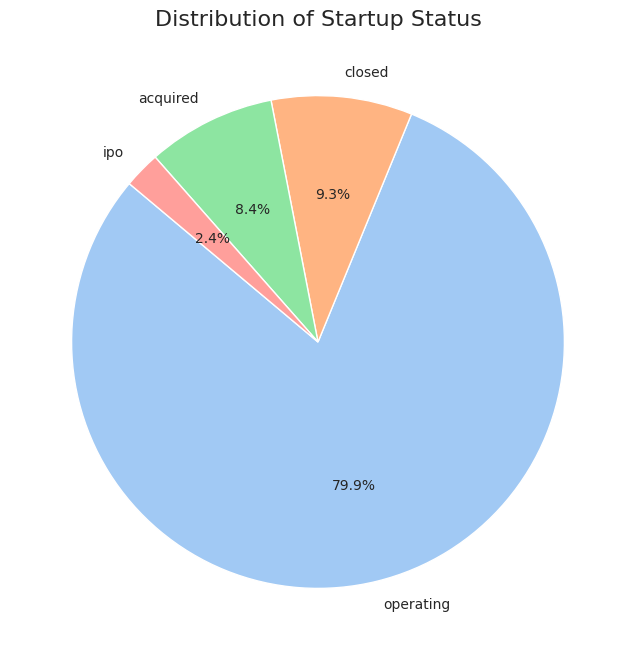

In [5]:
# 2.1 Status Distribution
status_counts = df['status'].value_counts()

plt.figure(figsize=(10, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribution of Startup Status', fontsize=16)
plt.show()

**Inference:** The pie chart shows the proportion of startups in each status (Operating, Acquired, Closed, IPO). This gives us a baseline success rate for the ecosystem.

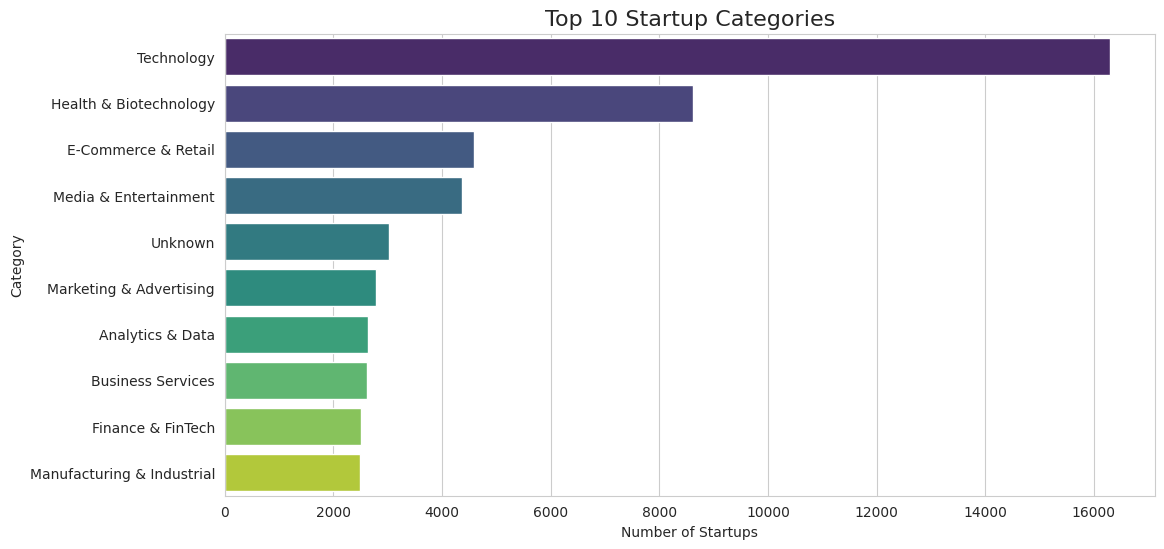

In [6]:
# 2.2 Top 10 Categories
top_categories = df['category'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
plt.title('Top 10 Startup Categories', fontsize=16)
plt.xlabel('Number of Startups')
plt.ylabel('Category')
plt.show()

**Inference:** This bar chart highlights the most popular sectors. We can see which industries are dominating the startup landscape.

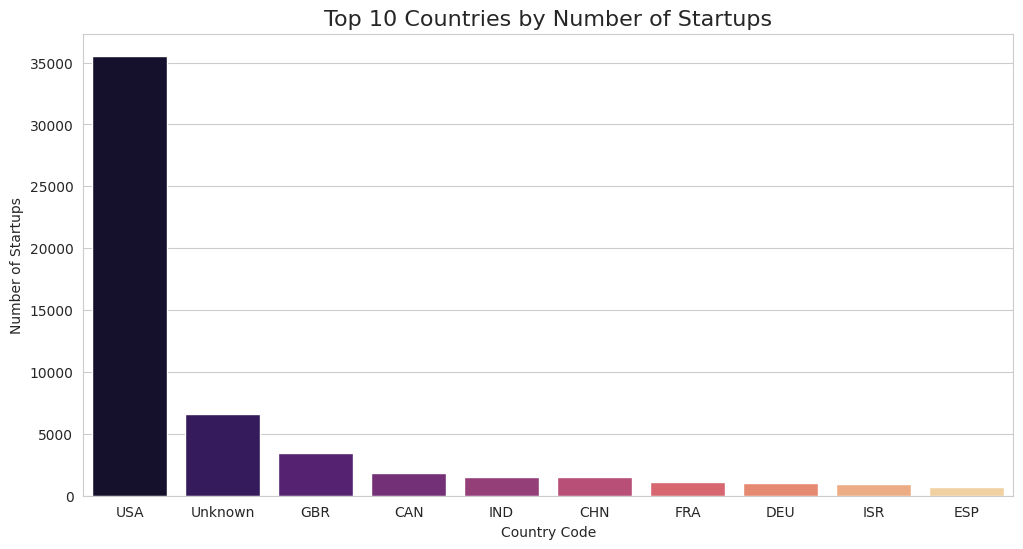

In [7]:
# 2.3 Top 10 Countries
top_countries = df['country_code'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.index, y=top_countries.values, palette='magma')
plt.title('Top 10 Countries by Number of Startups', fontsize=16)
plt.xlabel('Country Code')
plt.ylabel('Number of Startups')
plt.show()

**Inference:** This plot shows the geographic concentration of startups. It helps identify the major global hubs for innovation.

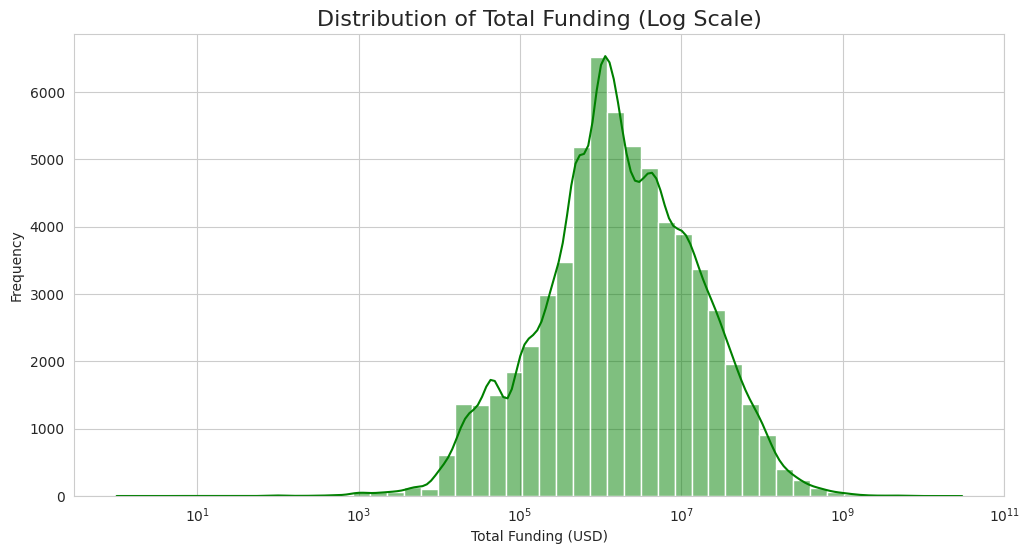

In [8]:
# 2.4 Funding Distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['funding_total_usd'], bins=50, kde=True, log_scale=True, color='green')
plt.title('Distribution of Total Funding (Log Scale)', fontsize=16)
plt.xlabel('Total Funding (USD)')
plt.ylabel('Frequency')
plt.show()

**Inference:** The funding distribution is highly skewed, so a log scale is used. This allows us to see the spread of funding from bootstrapped/seed stage to massive late-stage rounds.

## 3. Bivariate Analysis

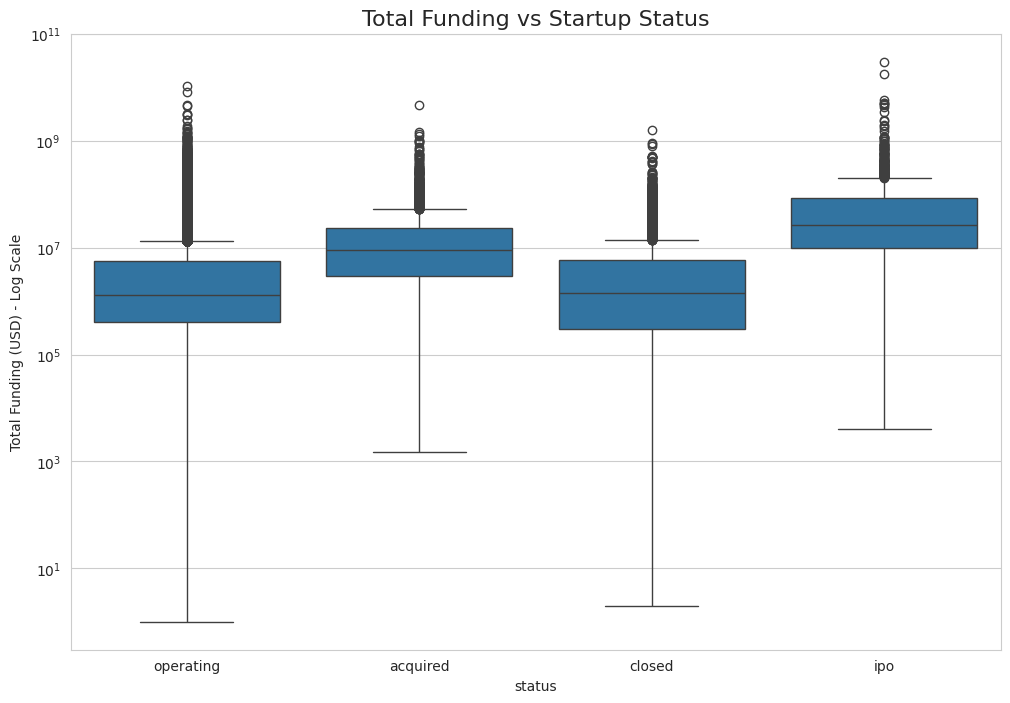

In [9]:
# 3.1 Funding vs Status
plt.figure(figsize=(12, 8))
sns.boxplot(x='status', y='funding_total_usd', data=df)
plt.yscale('log')
plt.title('Total Funding vs Startup Status', fontsize=16)
plt.ylabel('Total Funding (USD) - Log Scale')
plt.show()

**Inference:** This boxplot compares the funding levels across different outcomes. We typically expect IPO companies to have significantly higher median funding than closed or operating ones.

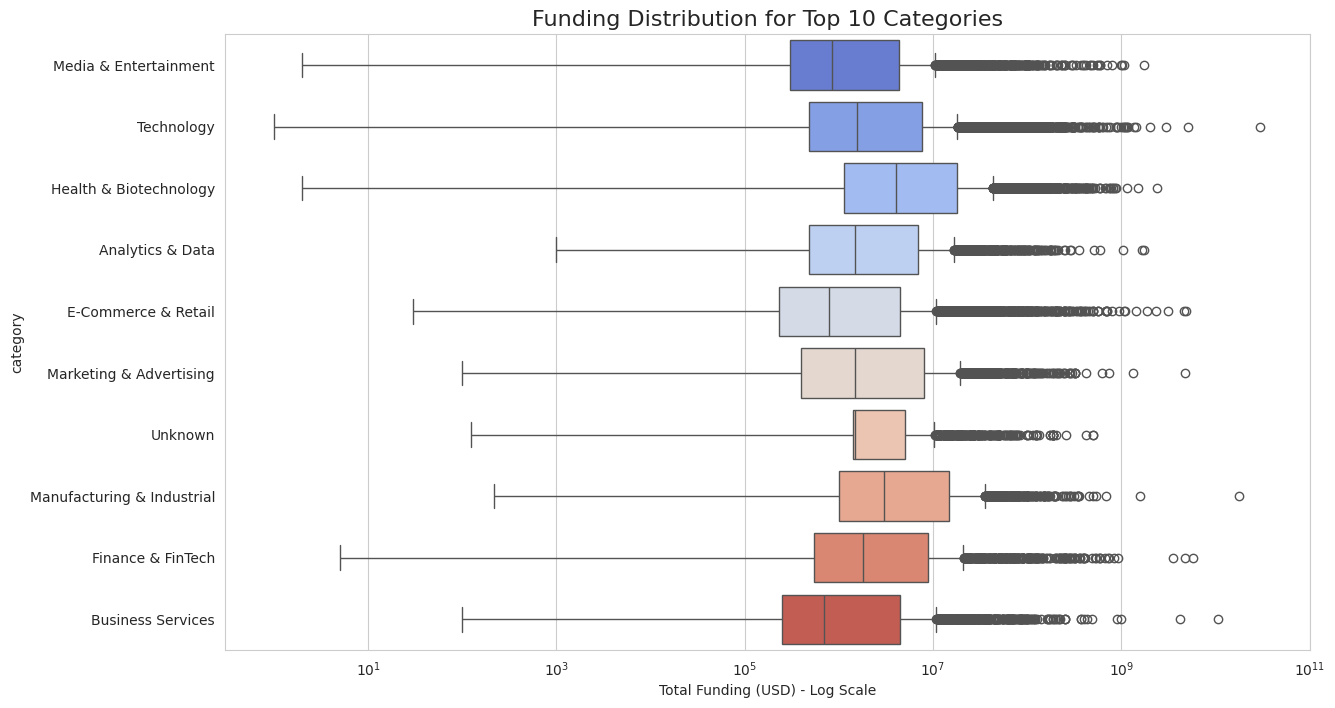

In [10]:
# 3.2 Funding vs Top Categories
top_cat_list = top_categories.index.tolist()
df_top_cat = df[df['category'].isin(top_cat_list)]

plt.figure(figsize=(14, 8))
sns.boxplot(x='funding_total_usd', y='category', data=df_top_cat, palette='coolwarm')
plt.xscale('log')
plt.title('Funding Distribution for Top 10 Categories', fontsize=16)
plt.xlabel('Total Funding (USD) - Log Scale')
plt.show()

**Inference:** This visualization reveals which sectors are the most capital-intensive. For example, Biotechnology often requires more capital than Software.

## 4. Temporal Analysis

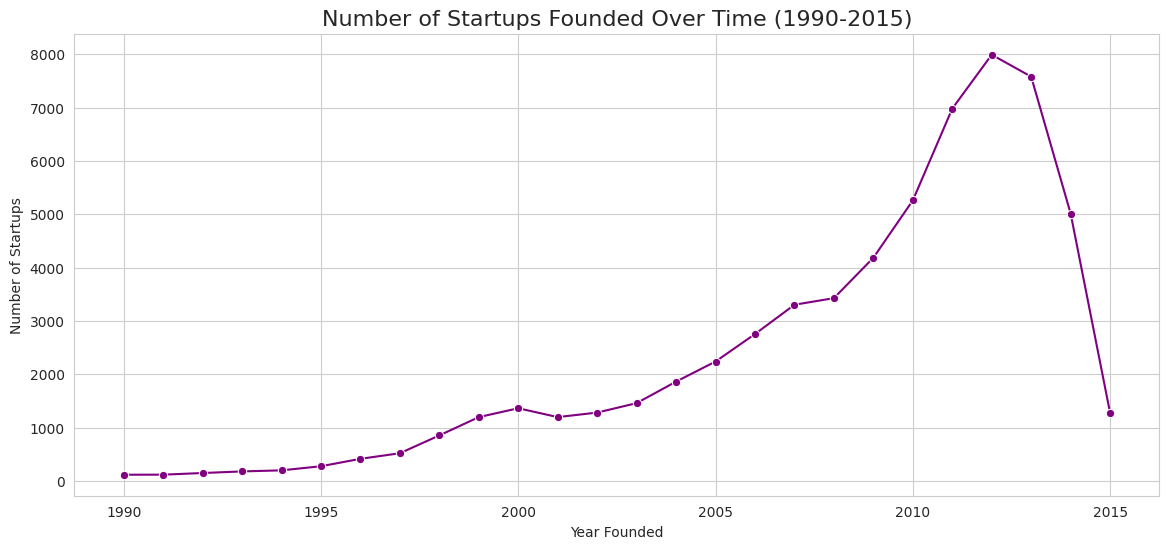

In [11]:
# 4.1 Startups Founded Over Time
founded_counts = df['founded_year'].value_counts().sort_index()
# Filter for reasonable year range (e.g., 1990 to 2015 to avoid sparse historical data or future errors)
founded_counts = founded_counts[(founded_counts.index >= 1990) & (founded_counts.index <= 2015)]

plt.figure(figsize=(14, 6))
sns.lineplot(x=founded_counts.index, y=founded_counts.values, marker='o', color='purple')
plt.title('Number of Startups Founded Over Time (1990-2015)', fontsize=16)
plt.xlabel('Year Founded')
plt.ylabel('Number of Startups')
plt.grid(True)
plt.show()

**Inference:** The trend line shows the boom and bust cycles of the startup ecosystem, such as the dot-com bubble or the post-2008 financial crisis recovery.

## 5. Correlation Analysis

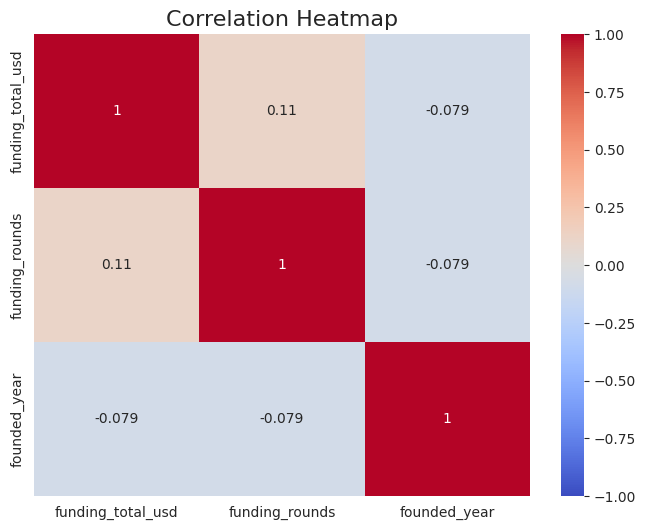

In [12]:
# 5.1 Correlation Heatmap
corr_cols = ['funding_total_usd', 'funding_rounds', 'founded_year']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

**Inference:** no strong linear relationships among these variables. Everything is mostly weakly correlated or independent.

## 6. Niche Visualizations I found

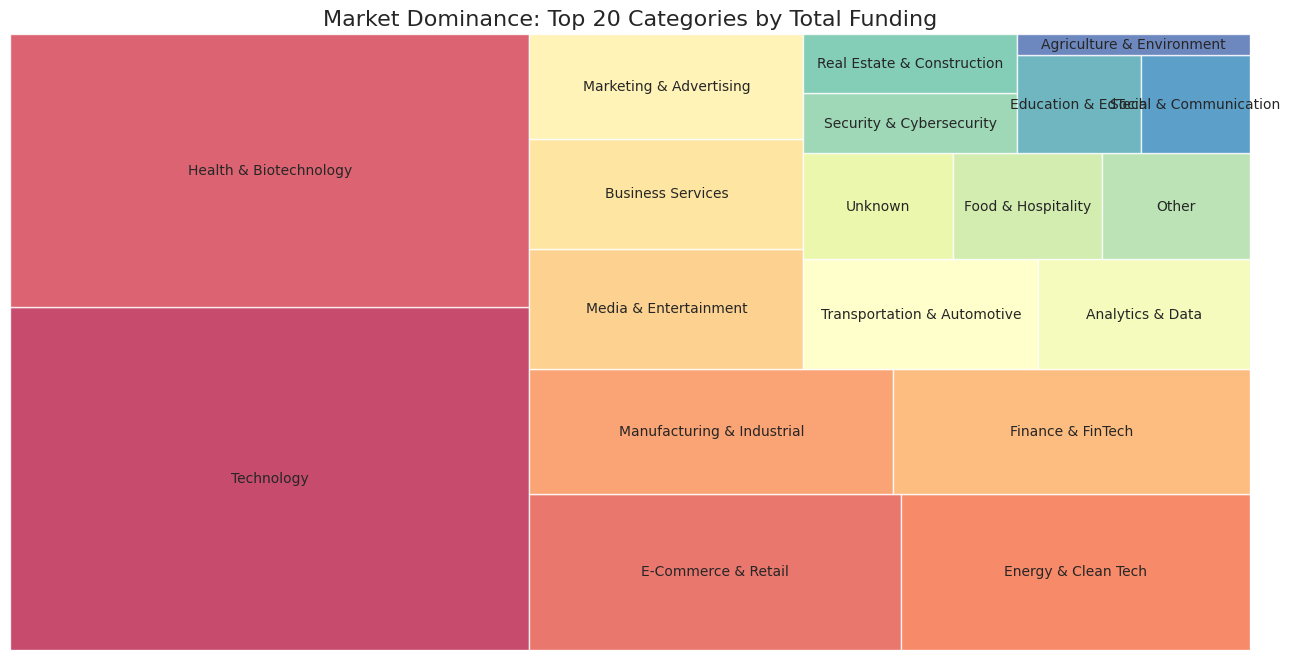

In [13]:
# 6.1 Treemap of Category Funding
# Aggregate funding by category
cat_funding = df.groupby('category')['funding_total_usd'].sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(16, 8))
squarify.plot(sizes=cat_funding.values, label=cat_funding.index, alpha=0.8, color=sns.color_palette("Spectral", len(cat_funding)))
plt.title('Market Dominance: Top 20 Categories by Total Funding', fontsize=16)
plt.axis('off')
plt.show()

**Inference:** The treemap provides a hierarchical view of where the money is going. Large blocks indicate categories that attract the most capital, revealing market dominance beyond just the *count* of startups.

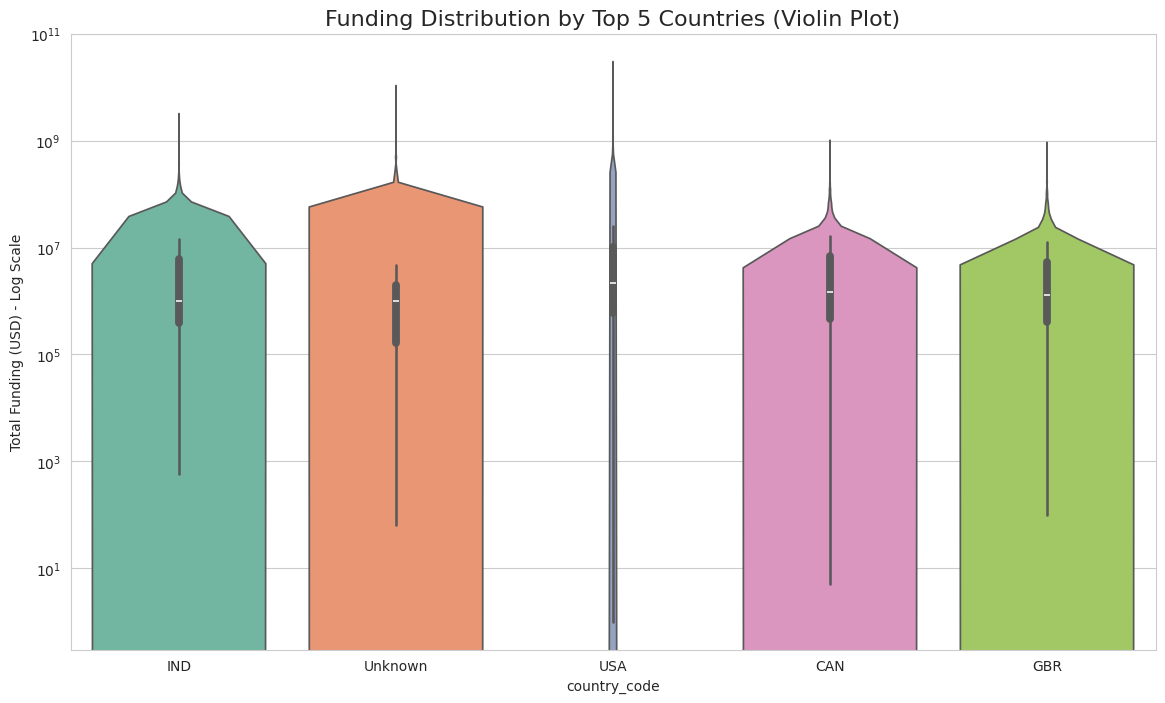

In [14]:
# 6.2 Violin Plots: Funding Landscape by Top Countries
top_5_countries = df['country_code'].value_counts().head(5).index
df_top_countries = df[df['country_code'].isin(top_5_countries)]

plt.figure(figsize=(14, 8))
sns.violinplot(x='country_code', y='funding_total_usd', data=df_top_countries, palette='Set2')
plt.yscale('log')
plt.title('Funding Distribution by Top 5 Countries (Violin Plot)', fontsize=16)
plt.ylabel('Total Funding (USD) - Log Scale')
plt.show()

**Inference:** The violin plot shows that all five countries have a very wide spread in funding, but the USA has the largest range, including the highest outliers. India, Canada, and the UK have similar mid-range funding distributions, while the “Unknown” group also shows high variability but with fewer extreme highs compared to the USA.

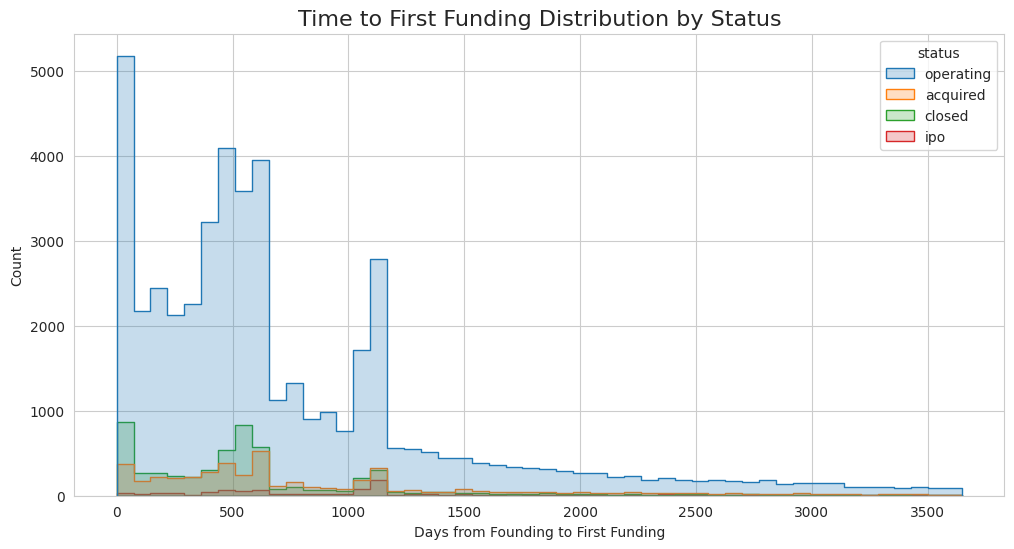

In [15]:
# 6.3 Time to First Funding Analysis
# Calculate time difference in days
df['days_to_first_funding'] = (df['first_funding_at'] - df['founded_at']).dt.days

# Filter for valid positive values (funding after founding)
df_valid_time = df[(df['days_to_first_funding'] >= 0) & (df['days_to_first_funding'] < 3650)] # < 10 years

plt.figure(figsize=(12, 6))
sns.histplot(data=df_valid_time, x='days_to_first_funding', hue='status', bins=50, element="step", common_norm=False)
plt.title('Time to First Funding Distribution by Status', fontsize=16)
plt.xlabel('Days from Founding to First Funding')
plt.show()

**Inference:** This plot investigates if speed to funding correlates with success. This chart shows that operating startups tend to secure their first funding much faster and in far larger numbers compared to acquired, closed, or IPO companies. Most non-operating groups (acquired/closed/IPO) also raise early, but in much smaller volumes suggesting that speed to first funding is common across outcomes, but only a subset of startups sustain long-term success.

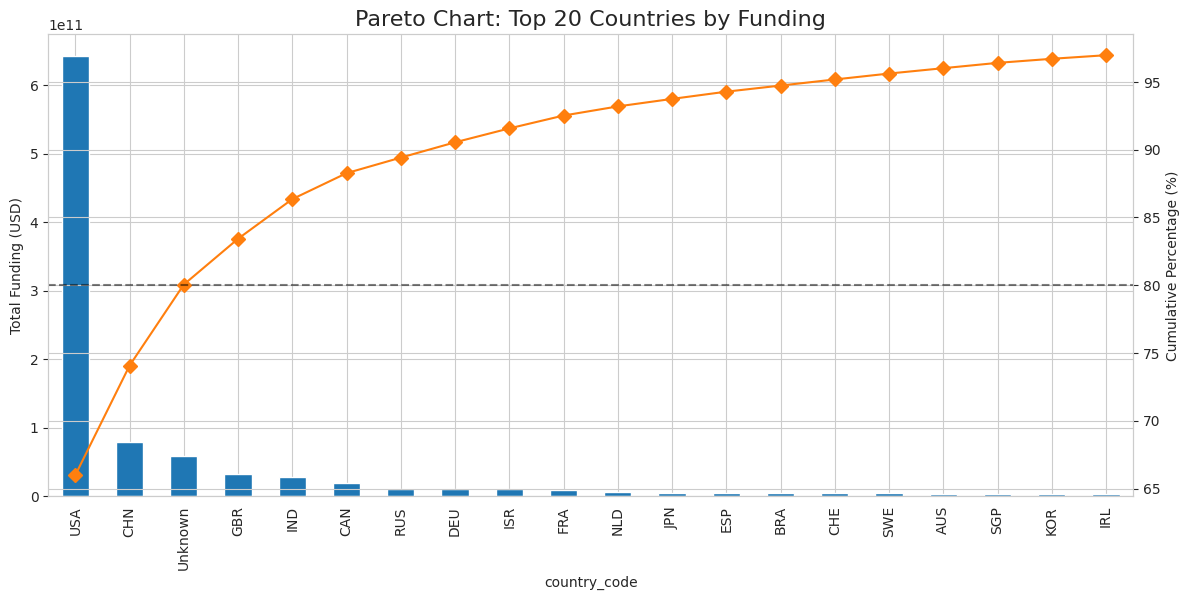

In [16]:
# 6.4 Pareto Analysis: Country Funding Concentration
country_funding = df.groupby('country_code')['funding_total_usd'].sum().sort_values(ascending=False)
cumulative_funding = country_funding.cumsum() / country_funding.sum() * 100

plt.figure(figsize=(14, 6))
ax1 = country_funding.head(20).plot(kind='bar', color='C0')
ax2 = ax1.twinx()
ax2.plot(cumulative_funding.head(20).values, color='C1', marker='D', ms=7)
ax2.axhline(80, color='k', linestyle='--', alpha=0.5)

ax1.set_ylabel('Total Funding (USD)')
ax2.set_ylabel('Cumulative Percentage (%)')
plt.title('Pareto Chart: Top 20 Countries by Funding', fontsize=16)
plt.show()

**Inference:** The Pareto chart tests the 80/20 rule. We can see how few countries account for the vast majority (80%) of global startup funding. If the curve hits 80% quickly, the market is highly concentrated.This Pareto chart shows that the USA overwhelmingly dominates total funding, far surpassing all other countries, with China and a few others contributing much smaller but still notable amounts. The top few countries account for roughly 80–90% of global funding, highlighting a highly concentrated funding landscape driven by a small group of nations.

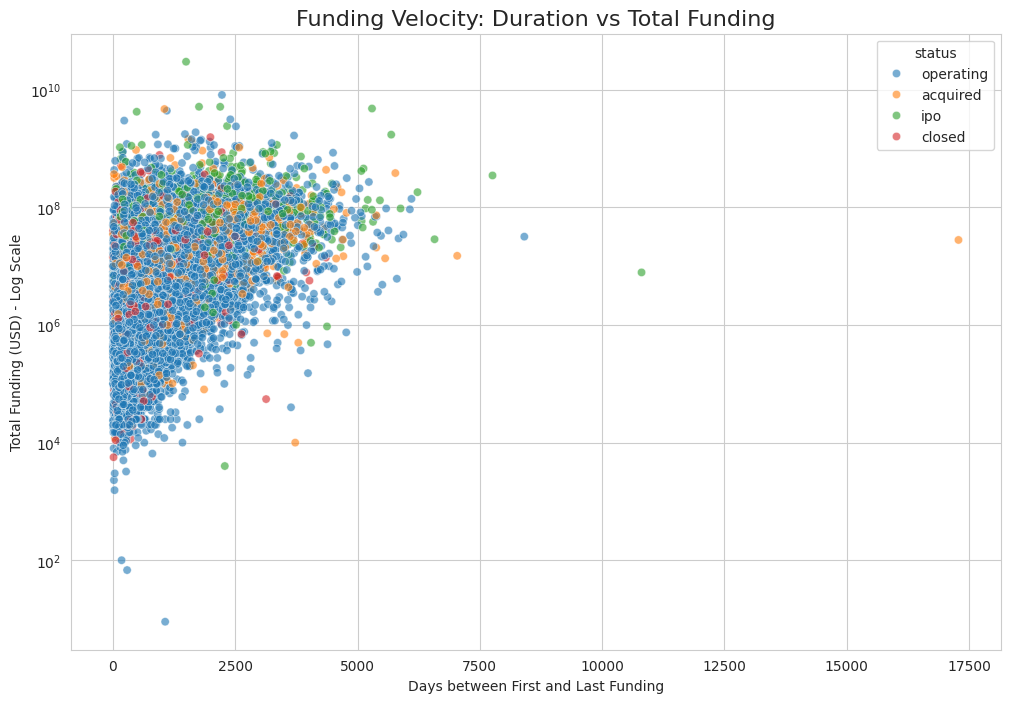

In [17]:
# 6.5 Funding Velocity vs Total Funding
# Calculate funding duration
df['funding_duration_days'] = (df['last_funding_at'] - df['first_funding_at']).dt.days
df_velocity = df[(df['funding_duration_days'] > 0) & (df['funding_total_usd'] > 0)]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='funding_duration_days', y='funding_total_usd', hue='status', data=df_velocity, alpha=0.6)
plt.yscale('log')
plt.title('Funding Velocity: Duration vs Total Funding', fontsize=16)
plt.xlabel('Days between First and Last Funding')
plt.ylabel('Total Funding (USD) - Log Scale')
plt.show()

**Inference:** This scatter plot looks for a "velocity" effect. Do companies that raise money over a longer period end up with more total capital, or do successful companies raise massive amounts in short bursts? The 'status' hue helps differentiate the trajectories of IPO vs Acquired vs Operating companies.